Import data and save to a database file for faster imports and temporary table saving

In [1]:
# optional step
# create sqlite3 db file from sec zip files for easier access in future file runs
# from pathlib import Path
# import sqlite3

# # setup sqlite3 connection
# conn = sqlite3.connect(r'C:\Users\kong_man\Documents\mrp_2025\sec.db')


# root = Path(r"C:\Users\kong_man\Documents\mrp_2025\project_exploration")
# # for each directory (eg q1 2024)
# for d in root.iterdir():
#     # if it is a directory
#     if d.is_dir():
#         # get the corresponding quarter and year from the filepath
#         quarter = str(d)[-2:]
#         year = str(d)[-6:-2]
#         print(f'{quarter} {year}')
#         # for each file in the directory
#         for filepath in d.iterdir():
#             # if not a readme file
#             if str(filepath)[-3:] == 'txt':
#                 table = pd.read_csv(filepath, sep='\t')
#                 table['quarter'] = quarter
#                 table['year'] = year
#                 table_name = str(filepath).rsplit("\\", 1)[-1][-7:-4]
#                 # upload the table to sec database
#                 table.to_sql(table_name, con=conn, if_exists='append')


In [2]:
# import data from text files
from pathlib import Path
import pandas as pd
import numpy as np

root = Path(r"C:\Users\kong_man\Documents\mrp_2025\project_exploration\raw_data")

# create empty lists
num = []
pre = []
sub = []
tag = []

# read text file as list
def read_txt(filepath):
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            # Remove leading/trailing whitespace and split the line by the delimiter
            processed_line = line.strip().split('\t')
            data.append(processed_line)
    # return the data without header
    return(data[1:])

# get column headers for rtables
def get_header(filepath):
    with open(filepath, 'r') as file:
        processed_line = file.readline().rstrip("\n").split('\t')
        return(processed_line)

# get headers for each list
num.append(get_header(f"{root}\\2020q1\\num.txt"))
pre.append(get_header(f"{root}\\2020q1\\pre.txt"))
sub.append(get_header(f"{root}\\2020q1\\sub.txt"))
tag.append(get_header(f"{root}\\2020q1\\tag.txt"))

# for each directory (eg 2024q1)
for d in root.iterdir():
    # if it is a directory
    if d.is_dir():
        # for each file in the directory
        for filepath in d.iterdir():
            # if not a readme file
            if str(filepath)[-3:] == 'txt':
                if str(filepath).rsplit("\\", 1)[-1][-7:-4] == 'num':
                    num.append(read_txt(filepath))
                elif str(filepath).rsplit("\\", 1)[-1][-7:-4] == 'pre':
                    pre.append(read_txt(filepath))
                elif str(filepath).rsplit("\\", 1)[-1][-7:-4] == 'sub':
                    sub.append(read_txt(filepath))
                elif str(filepath).rsplit("\\", 1)[-1][-7:-4] == 'tag':
                    tag.append(read_txt(filepath))

# convert all 4 tables to dataframes
num_df = pd.DataFrame(num[2][1:], columns=num[0])
pre_df = pd.DataFrame(pre[2][1:], columns=pre[0])
sub_df = pd.DataFrame(sub[2][1:], columns=sub[0])
tag_df = pd.DataFrame(tag[2][1:], columns=tag[0])

In [3]:
# manage datatypes
sub_df['cik'] = pd.to_numeric(sub_df['cik'])

Import Tickers File to get tickers from company name in sub table

In [4]:
# get the stock ticker given the company name
import requests 
UA = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

def sec_table() -> pd.DataFrame:
    """Load SEC company tickers + exchanges as a DataFrame."""
    url = "https://www.sec.gov/files/company_tickers_exchange.json"
    j = requests.get(url, headers=UA, timeout=30).json()
    df = pd.DataFrame.from_dict(j, orient="index")
    # expected columns: cik_str, ticker, title, exchange
    cols = [f["name"] if isinstance(f, dict) and "name" in f else f for f in j["fields"]]
    df = pd.DataFrame(j["data"], columns=cols)
    return df

In [5]:
# only get relevant exchanges
sec_ref_df = sec_table()
sec_ref_df2 = sec_ref_df[sec_ref_df['exchange'].isin(['NYSE', 'Nasdaq'])]

# remove duplicates, use the shortest name
sec_ref_df3 = sec_ref_df2.sort_values('ticker').drop_duplicates(subset='cik').reset_index(drop=True)

In [6]:
# get ticker from cik
# 1. join with sub_df to get cik
# 2. join with sec_ref_df to get stock ticker
# 3. remove missing cik matches
merged_stock_df = num_df.merge(sub_df[['adsh', 'cik', 'name', 'accepted']], how='left', on='adsh')\
                        .merge(sec_ref_df3, how='left', on='cik')\
                        .drop('name_y', axis='columns')\
                        .rename(columns={"name_x":"name"})
non_missing_tickers = merged_stock_df[merged_stock_df['ticker'].notnull()]
# get no dupe tickers
no_dupe_tickers = non_missing_tickers.loc[non_missing_tickers['ticker'].duplicated()==False, ['accepted', 'ticker']]

In [7]:
import yfinance as yf
from datetime import time
from time import sleep
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def prices_at_offsets(ticker, anchor, mode="trading", start_next_session=False):
    anchor = pd.to_datetime(anchor)
    start = (anchor - pd.Timedelta(days=3)).date()
    end   = (anchor + pd.Timedelta(days=40)).date()

    px = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    if px.empty or "Close" not in px:
        return pd.Series({"P0": np.nan, "P+1": np.nan, "P+7": np.nan, "P+14": np.nan})

    close = px["Close"].copy()
    close.index = pd.to_datetime(close.index).tz_localize(None)
    dates = close.index

    if start_next_session:
        anchor_et = anchor.tz_localize("UTC").tz_convert("America/New_York") if anchor.tzinfo else anchor.tz_localize("America/New_York")
        if anchor_et.time() >= time(16, 0):
            anchor = (anchor.normalize() + pd.Timedelta(days=1))

    p0_pos = dates.searchsorted(anchor.normalize(), side="left")
    if p0_pos >= len(dates):
        return pd.Series({"P0": np.nan, "P+1": np.nan, "P+7": np.nan, "P+14": np.nan})

    if mode == "trading":
        pos = {
            "P0": p0_pos,
            "P+1": min(p0_pos + 1,  len(dates)-1),
            "P+7": min(p0_pos + 7,  len(dates)-1),
            "P+14":min(p0_pos + 14, len(dates)-1),
        }
    else:
        def snap(d):
            i = dates.searchsorted(d.normalize(), side="left")
            return None if i >= len(dates) else i
        pos = {
            "P0": p0_pos,
            "P+1": snap(anchor + pd.Timedelta(days=1)),
            "P+7": snap(anchor + pd.Timedelta(days=7)),
            "P+14":snap(anchor + pd.Timedelta(days=14)),
        }

    out = {k: (np.nan if v is None else float(close.iloc[v])) for k, v in pos.items()}
    sleep(1)
    return pd.Series(out)

#prices_at_offsets("IDT", "2020-02-11", mode="trading", start_next_session=True)

In [8]:
# do not run if ticker_ref_df already generated
# iterate through all tickers and append p0/p+1/p+7/p+14 to list
# p0 = closing price the day of, p+1 = closing price the day after, etc.
# rows = []
# count = 0
# for t, a in zip(no_dupe_tickers['ticker'], no_dupe_tickers['accepted']):
#     try:
#         s = prices_at_offsets(t, a, mode='trading', start_next_session=True)
#     except Exception:
#         s = pd.Series({"P0": np.nan, "P+1": np.nan, "P+7": np.nan, "P+14": np.nan})
#     rows.append(s)
#     count +=1
#     if count % 100 == 0:
#         print(f"Done {count} ticker(s).")
# no_dupe_tickers2 =no_dupe_tickers.reset_index(drop=True)
# # merged df with tickers and p0/p+1/p+7/p+14
# ticker_ref_df = pd.concat([no_dupe_tickers2,pd.DataFrame(rows)], axis=1)

In [9]:
# optional: save ticker_ref_df cuz it takes so long to run
#ticker_ref_df.to_csv('ticker_ref.csv', index=False)
ticker_fp = r"C:\Users\kong_man\Documents\mrp_2025\project_exploration"
ticker_ref_df = pd.read_csv(f'{ticker_fp}\\ticker_ref.csv')


In [10]:
# drop missing data
# also drop accepted date as its no longer necessary
no_miss_ticker_ref = ticker_ref_df[ticker_ref_df['P0'].notnull()].reset_index(drop=True).drop('accepted', axis=1)
# drop negative p0 as it is incorrectly pulled
no_miss_ticker_ref2 = no_miss_ticker_ref[no_miss_ticker_ref['P0']>0]
# rejoin to original table 
num_df_exp = non_missing_tickers.merge(no_miss_ticker_ref2, how='left', on='ticker')

Data Cleaning and Feature Engineering

In [11]:
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


In [12]:
# join tag metadata
meta_cols = [c for c in ['tag','tlabel','doc','datatype','iord','custom', 'version'] if c in tag_df.columns]
num_df_mer = num_df_exp.merge(tag_df[meta_cols], on=['tag', 'version'], how='left')

In [13]:
# organize filing by unique file
g = num_df_mer.groupby('adsh', as_index=False)

# segments features
def entropy(s):
    cnt = s.value_counts()
    p = cnt / cnt.sum() if cnt.sum() else cnt
    return float(-(p * np.log(p + 1e-12)).sum())

seg_agg = g['segments'].agg(
    seg_share=lambda s: (s.str.len() > 0).mean(),
    seg_unique=lambda s: s.replace('', np.nan).nunique(),
    seg_entropy=lambda s: entropy(s[s.str.len() > 0])
)

In [40]:
# generate uom columns 
num_df = num_df_mer.copy()
num_df['uom'] = num_df['uom'].astype(str).str.strip()

# regular expression matching
ISO3 = re.compile(r'^[A-Z]{3}$') 
PER_SHARE = re.compile(r'^(?P<ccy>[A-Z]{3})/(SHARE|SHARES|EQUITYINSTRUMENT)$', re.I)
FX_PAIR = re.compile(r'^(?P<b>[A-Z]{3})/(?P<q>[A-Z]{3})$')

PHYS_UNITS = {'OZ','ACRE'}                        
COUNT_TOKENS = {'NUMBER','VOTE','ITEM','STORES','STORE'}  
CRYPTO_TOKENS = {'BITCOIN'}

def uom_bucket(u):
    u_stripped = (u or '').strip()
    u_up = u_stripped.upper().replace(' ', '')
    # simple buckets first
    if u_up in {'PURE','PERCENT','%','RATE'}:
        return 'PURE_PCT'
    if u_up in {'SHARE','SHARES'}:
        return 'SHARES'
    if u_up in PHYS_UNITS:
        return 'PHYS_UNIT'
    if u_up in COUNT_TOKENS:
        return 'COUNT'
    if u_up in CRYPTO_TOKENS:
        return 'CRYPTO'

    if PER_SHARE.match(u_up):
        return 'PER_SHARE'

    if FX_PAIR.match(u_up):
        return 'FX_PAIR'

    if ISO3.match(u_up):
        return 'CUR_USD' if u_up == 'USD' else 'CUR_NONUSD'

    return 'OTHER'

def extract_currency(u):
    u_up = (u or '').strip().upper().replace(' ', '')
    if ISO3.match(u_up):
        return u_up
    m = PER_SHARE.match(u_up)
    if m:
        return m.group('ccy').upper()
    return None

df = num_df.copy()
df['uom_bucket'] = df['uom'].map(uom_bucket)
df['uom_ccy'] = df['uom'].map(extract_currency)

uom_prop = (pd.crosstab(df['adsh'], df['uom_bucket'], normalize='index')
              .add_prefix('uom_')
              .reset_index())

ccy_stats = (df.groupby('adsh')['uom_ccy']
               .agg(n_currencies=lambda s: s.dropna().nunique(),
                    has_nonusd=lambda s: int(s.dropna().isin(['USD']).sum() < s.dropna().size if s.dropna().size else 0))
               .reset_index())

cur_mask = df['uom_bucket'].isin(['CUR_USD','CUR_NONUSD','PER_SHARE'])
usd_share = (df[cur_mask]
             .assign(is_usd=lambda d: (d['uom_ccy'] == 'USD').astype(int))
             .groupby('adsh')['is_usd'].mean()
             .rename('usd_share_of_currency')
             .reset_index())

uom_features = (uom_prop
    .merge(ccy_stats, on='adsh', how='left')
    .merge(usd_share, on='adsh', how='left')
    .fillna({'usd_share_of_currency': 0.0, 'n_currencies': 0, 'has_nonusd': 0}))

In [15]:
# bag of tags for tdif and svd
# use tag names as tokens
bag = (num_df_mer[['adsh','tag']].drop_duplicates()
       .groupby('adsh')['tag'].apply(lambda s: ' '.join(s.astype(str))).reset_index())

tf = TfidfVectorizer(token_pattern=r'[^ ]+', max_features=8000)
X = tf.fit_transform(bag['tag'])
svd = TruncatedSVD(n_components=20, random_state=0)
Z = svd.fit_transform(X)
emb = pd.DataFrame(Z, columns=[f'tag_svd{i+1}' for i in range(Z.shape[1])])
emb.insert(0, 'adsh', bag['adsh'].values)

In [16]:
# join features
parts = [seg_agg, uom_features,emb]
feat = parts[0]
for p in parts[1:]:
    feat = feat.merge(p, on='adsh', how='left')
feat = feat.fillna(0.0)

In [17]:
# generate filing table with only one row per unique adsh
filings = num_df_mer[['adsh', 'cik', 'qtrs', 'accepted', 'ticker', 'P0', 'P+1', 'P+7', 'P+14']].drop_duplicates('adsh').reset_index(drop=True)
# join with features dataframe
filings_df_merg = filings.merge(feat, on='adsh', how='left')
# drop missing labels
model_df = filings_df_merg[filings_df_merg['P0'].notnull()].reset_index(drop=True)

Generate class labels from stock price values after 1/7/14 days

In [18]:
# +1 if > P0 
# else 0
cols = ['P+1','P+7','P+14']
categorical_target = model_df[cols].gt(model_df['P0'], axis=0).astype(int)
model_df_cls = model_df.drop(cols, axis=1).join(categorical_target)
model_df_cls

,adsh,cik,qtrs,accepted,ticker,P0,seg_share,seg_unique,seg_entropy,uom_COUNT,...,tag_svd14,tag_svd15,tag_svd16,tag_svd17,tag_svd18,tag_svd19,tag_svd20,P+1,P+7,P+14
0,0001178879-20-000023,1178879.0,0,2020-05-07 16:31:00.0,FOLD,11.670000,0.223077,8,1.731696e+00,0.0,...,-0.023832,-0.074619,0.141998,-0.009002,-0.032622,0.012934,-0.056929,1,1,1
1,0001564590-20-023293,1126956.0,0,2020-05-08 10:05:00.0,SR,58.851883,0.727402,58,2.791743e+00,0.0,...,0.098084,-0.000119,-0.176255,-0.012267,0.040117,-0.078334,-0.010736,0,0,0
2,0001488813-20-000134,1488813.0,1,2020-05-11 17:32:00.0,CUBB,15.083270,0.573487,155,4.505868e+00,0.0,...,0.010774,0.001144,-0.042400,0.011420,0.011482,0.026268,-0.037799,1,1,1
3,0000887343-20-000149,887343.0,0,2020-05-07 20:10:00.0,COLB,18.705645,0.435849,58,3.787177e+00,0.0,...,0.006071,0.021897,0.033064,-0.068140,-0.022602,0.000347,0.020332,0,0,1
4,0000107815-20-000180,783325.0,0,2020-05-06 17:59:00.0,WEC,71.131859,0.579848,48,3.358023e+00,0.0,...,0.058561,0.048193,-0.101324,-0.106945,0.053457,-0.069554,0.019999,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3507,0001104659-20-070367,1800347.0,0,2020-06-05 16:54:00.0,ETWO,9.900000,0.500000,10,2.066603e+00,0.0,...,-0.034270,0.046682,-0.057802,0.010767,0.023867,0.013891,0.004890,1,1,1
3508,0001654954-20-005004,1645469.0,0,2020-05-07 08:58:00.0,MNPR,38.000000,0.272727,4,1.342113e+00,0.0,...,0.014208,-0.032901,0.166125,-0.031927,-0.039736,0.015865,-0.035594,1,1,1
3509,0001575705-20-000049,933972.0,4,2020-04-14 17:15:00.0,SCWO,0.220000,0.202614,4,1.373021e+00,0.0,...,0.118320,0.048656,0.125117,-0.015352,-0.027223,0.078707,0.048872,0,1,0
3510,0001460235-20-000006,1460235.0,0,2020-05-08 12:57:00.0,PPLT,72.480003,0.083333,1,-1.000089e-12,0.0,...,-0.081384,0.097391,0.009949,0.030607,0.012827,0.187643,-0.020333,0,1,1


In [42]:
# 'n_currencies', 'has_nonusd', 'usd_share_of_currency',
model_df_cls['n_currencies'].value_counts()

n_currencies
1     3231
2      245
3       25
4        6
8        2
6        1
7        1
32       1
Name: count, dtype: int64

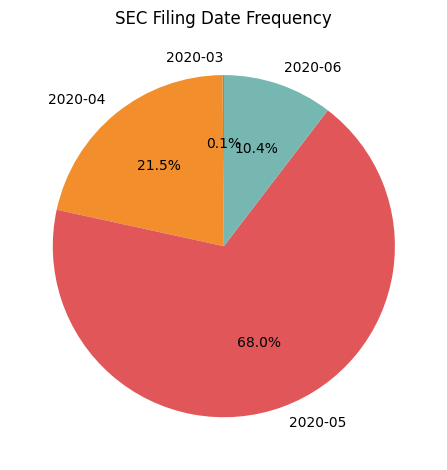

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

model_df_cls_copy = model_df_cls
model_df_cls_copy['date'] = pd.to_datetime(model_df_cls['accepted'], errors='coerce')
s = model_df_cls_copy['date'].dropna()

freq = s.dt.to_period('M').value_counts().sort_index()
freq.index = freq.index.astype(str)

N = 8
if len(freq) > N:
    top = freq.head(N)
    other = pd.Series({'Other': freq.iloc[N:].sum()})
    freq = pd.concat([top, other])


nice = ['#4E79A7','#F28E2B','#E15759','#76B7B2','#59A14F',
        '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AC']


ax = freq.plot(
    kind='pie', 
    autopct='%.1f%%', 
    startangle=90, 
    ylabel='',
    colors=nice[:len(freq)],
    )
ax.set_title('SEC Filing Date Frequency')
plt.tight_layout()
plt.show()


Split data into training and testing datasets

In [28]:
from sklearn.model_selection import train_test_split
def train_test(model_df, stratify=True, test_size=0.2):
    # features = all numeric columns except admin/target/price columns
    exclude = {"adsh","cik","qtrs", 'accepted', "P+1","P+7","P+14", 'ticker'}
    feature_cols = [c for c in model_df.columns
                    if c not in exclude and pd.api.types.is_numeric_dtype(model_df[c])]

    X = model_df[feature_cols]
    y = model_df[["P+1","P+7","P+14"]]
    # if regression, then shuffle
    # otherwise stratify
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, shuffle=True
        )
    return X_train, X_test, y_train, y_test

In [39]:
y_train_cls['P+14'].value_counts()

P+14
1    1919
0     890
Name: count, dtype: int64

In [30]:
# generate testing and training for classification models
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test(model_df_cls)

In [48]:
# generate testing and training for regression models
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test(model_df, stratify=False)

In [49]:
# send data to flat files
X_train_cls.to_csv('x_train_class.csv', index=False)
X_test_cls.to_csv('x_test_class.csv', index=False)
y_train_cls.to_csv('y_train_class.csv', index=False)
y_test_cls.to_csv('y_test_class.csv', index=False)

X_train_reg.to_csv('x_train_reg.csv', index=False)
X_test_reg.to_csv('x_test_reg.csv', index=False)
y_train_reg.to_csv('y_train_reg.csv', index=False)
y_test_reg.to_csv('y_test_reg.csv', index=False)